### Imports

In [1]:
# Remove unwanted warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

# Data Management
import polars as pl
import pandas as pd
from pandas_datareader.data import DataReader
from ta import add_all_ta_features
import yfinance as yf


# Statistics 
from statsmodels.tsa.stattools import adfuller

# Unsupervised Machine Learning
from sklearn.decomposition import PCA # Principle Component Analysis

# Supervised Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score

# Reporting
import matplotlib.pyplot as plt



### Initial Data Extraction

In [2]:
# Data Extraction
import yfinance as yf

start_date = '2017-01-01'
end_date = '2022-06-01'
symbol = '^VIX'
df_pd = yf.download(symbol, start=start_date, end=end_date)
df_pd.head()


[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03,14.07,14.07,12.85,12.85,12.85,0
2017-01-04,12.78,12.80,11.63,11.85,11.85,0
2017-01-05,11.96,12.09,11.40,11.67,11.67,0
2017-01-06,11.70,11.74,10.98,11.32,11.32,0
2017-01-09,11.71,12.08,11.46,11.56,11.56,0


In [3]:
# Convert to Polars DataFrame

# Reset the index to make the date a column
df_pd.reset_index(inplace=True)

df = pl.from_pandas(df_pd)
print(df.head)

<bound method DataFrame.head of shape: (1_362, 7)
┌─────────────────────┬───────────┬───────────┬───────────┬───────────┬───────────┬────────┐
│ Date                ┆ Open      ┆ High      ┆ Low       ┆ Close     ┆ Adj Close ┆ Volume │
│ ---                 ┆ ---       ┆ ---       ┆ ---       ┆ ---       ┆ ---       ┆ ---    │
│ datetime[ns]        ┆ f64       ┆ f64       ┆ f64       ┆ f64       ┆ f64       ┆ i64    │
╞═════════════════════╪═══════════╪═══════════╪═══════════╪═══════════╪═══════════╪════════╡
│ 2017-01-03 00:00:00 ┆ 14.07     ┆ 14.07     ┆ 12.85     ┆ 12.85     ┆ 12.85     ┆ 0      │
│ 2017-01-04 00:00:00 ┆ 12.78     ┆ 12.8      ┆ 11.63     ┆ 11.85     ┆ 11.85     ┆ 0      │
│ 2017-01-05 00:00:00 ┆ 11.96     ┆ 12.09     ┆ 11.4      ┆ 11.67     ┆ 11.67     ┆ 0      │
│ 2017-01-06 00:00:00 ┆ 11.7      ┆ 11.74     ┆ 10.98     ┆ 11.32     ┆ 11.32     ┆ 0      │
│ 2017-01-09 00:00:00 ┆ 11.71     ┆ 12.08     ┆ 11.46     ┆ 11.56     ┆ 11.56     ┆ 0      │
│ …                 

In [4]:
df.schema


OrderedDict([('Date', Datetime(time_unit='ns', time_zone=None)),
             ('Open', Float64),
             ('High', Float64),
             ('Low', Float64),
             ('Close', Float64),
             ('Adj Close', Float64),
             ('Volume', Int64)])

In [5]:
# Convert the 'Date' column to the desired timezone (New York)
df = df.with_columns(
    pl.col('Date').dt.replace_time_zone('America/New_York')
)

print(df.head())

shape: (5, 7)
┌────────────────────────────────┬───────┬───────┬───────┬───────┬───────────┬────────┐
│ Date                           ┆ Open  ┆ High  ┆ Low   ┆ Close ┆ Adj Close ┆ Volume │
│ ---                            ┆ ---   ┆ ---   ┆ ---   ┆ ---   ┆ ---       ┆ ---    │
│ datetime[ns, America/New_York] ┆ f64   ┆ f64   ┆ f64   ┆ f64   ┆ f64       ┆ i64    │
╞════════════════════════════════╪═══════╪═══════╪═══════╪═══════╪═══════════╪════════╡
│ 2017-01-03 00:00:00 EST        ┆ 14.07 ┆ 14.07 ┆ 12.85 ┆ 12.85 ┆ 12.85     ┆ 0      │
│ 2017-01-04 00:00:00 EST        ┆ 12.78 ┆ 12.8  ┆ 11.63 ┆ 11.85 ┆ 11.85     ┆ 0      │
│ 2017-01-05 00:00:00 EST        ┆ 11.96 ┆ 12.09 ┆ 11.4  ┆ 11.67 ┆ 11.67     ┆ 0      │
│ 2017-01-06 00:00:00 EST        ┆ 11.7  ┆ 11.74 ┆ 10.98 ┆ 11.32 ┆ 11.32     ┆ 0      │
│ 2017-01-09 00:00:00 EST        ┆ 11.71 ┆ 12.08 ┆ 11.46 ┆ 11.56 ┆ 11.56     ┆ 0      │
└────────────────────────────────┴───────┴───────┴───────┴───────┴───────────┴────────┘


In [6]:
# Add TA
# Convert back to Pandas DataFrame
df_pd = df.to_pandas()

# Add technical analysis features
df_pd = add_all_ta_features(df_pd, open='Open', high='High', low='Low', close='Adj Close', volume='Volume', fillna=True)

# Convert back to Polars Dataframe, remember need to have the pyarrow module installed
df = pl.from_pandas(df_pd)

In [7]:
df.head(3)

Date,Open,High,Low,Close,Adj Close,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,volume_sma_em,volume_vpt,volume_vwap,volume_mfi,volume_nvi,volatility_bbm,volatility_bbh,volatility_bbl,volatility_bbw,volatility_bbp,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kcw,volatility_kcp,volatility_kchi,volatility_kcli,volatility_dcl,volatility_dch,volatility_dcm,volatility_dcw,volatility_dcp,volatility_atr,…,trend_ichimoku_a,trend_ichimoku_b,trend_stc,trend_adx,trend_adx_pos,trend_adx_neg,trend_cci,trend_visual_ichimoku_a,trend_visual_ichimoku_b,trend_aroon_up,trend_aroon_down,trend_aroon_ind,trend_psar_up,trend_psar_down,trend_psar_up_indicator,trend_psar_down_indicator,momentum_rsi,momentum_stoch_rsi,momentum_stoch_rsi_k,momentum_stoch_rsi_d,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
"datetime[ns, America/New_York]",f64,f64,f64,f64,f64,i64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2017-01-03 00:00:00 EST,14.07,14.07,12.85,12.85,12.85,0,-0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,1000.0,12.85,12.85,12.85,0.0,0.0,0.0,0.0,13.256667,14.476666,12.036668,18.405823,0.333333,0.0,0.0,12.85,14.07,13.46,9.494158,0.0,0.0,…,13.46,13.46,0.0,0.0,0.0,0.0,0.0,20.47047,22.23312,0.0,0.0,0.0,10.94,14.07,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.85,0.0,0.0,0.0
2017-01-04 00:00:00 EST,12.78,12.8,11.63,11.85,11.85,0,-0.0,0,0.0,-0.0,0.0,0.0,0.0,0.0,50.0,1000.0,12.35,13.35,11.35,16.194331,0.25,0.0,0.0,12.675,13.87,11.48,18.856011,0.154812,0.0,0.0,11.63,14.07,12.85,19.757081,0.090164,0.0,…,12.85,12.85,0.0,0.0,0.0,0.0,-66.666667,20.47047,22.23312,0.0,4.0,-4.0,10.94,14.07,0.0,0.0,0.0,0.0,0.0,0.0,-100.0,9.016406,9.016406,4.508203,-90.983594,0.0,0.0,-0.624394,-0.124879,-0.499515,0.0,0.0,0.0,12.098375,-7.782101,-8.101594,-7.782101
2017-01-05 00:00:00 EST,11.96,12.09,11.4,11.67,11.67,0,-0.0,0,0.0,-0.0,0.0,0.0,0.0,0.0,50.0,1000.0,12.123334,13.161452,11.085215,17.125952,0.281656,0.0,0.0,12.356667,13.383333,11.33,16.61721,0.165584,0.0,0.0,11.4,14.07,12.735,22.023646,0.101124,0.0,…,12.735,12.735,0.0,0.0,0.0,0.0,-70.740755,20.47047,22.23312,0.0,8.0,-8.0,10.94,14.07,0.0,1.0,0.0,0.0,0.0,0.0,-100.0,15.654975,10.112376,6.376261,-89.887624,0.0,0.0,-1.226732,-0.345249,-0.881483,0.0,0.0,0.0,11.82578,-1.51899,-1.530645,-9.182881


## Data Processing -Stationarity 

In [8]:
# Convert back to Pandas DataFrame for ADF test
df_pd = df.to_pandas()

# Identify non-stationary columns
non_stationaries = []

# Loop through each column in the DataFrame
for col in df_pd.columns:
    if col != 'Date':  # Exclude the Date column
        series = df_pd[col].dropna().values  # Drop missing values
        if series.max() != series.min():  # Check if the series is not constant
            dftest = adfuller(series)  # Perform the Augmented Dickey-Fuller test
            p_value = dftest[1]  # Extract the p-value from the ADF test results
            t_test = dftest[0] < dftest[4]['1%']  # Check if the test statistic is less than the 1% critical value
            if p_value > 0.05 or not t_test:  # Check if the series is non-stationary
                non_stationaries.append(col)  # Add the column to the list of non-stationary columns


print(f"Non-Stationary Features Found: {len(non_stationaries)}")

# Convert the DataFrame back to Polars if needed for further processing
df = pl.from_pandas(df_pd)

Non-Stationary Features Found: 15


In [9]:
df_pd.dtypes

Date                 datetime64[ns, America/New_York]
Open                                          float64
High                                          float64
Low                                           float64
Close                                         float64
                                   ...               
momentum_pvo_hist                             float64
momentum_kama                                 float64
others_dr                                     float64
others_dlr                                    float64
others_cr                                     float64
Length: 93, dtype: object

In [10]:
from statsmodels.tsa.stattools import adfuller
import numpy as np
import pandas as pd

def analyze_column(col_name, values):
    if np.all(values == values[0]):
        return "constant"
    elif np.all(np.isnan(values)):
        return "all_nan"
    elif np.any(np.isnan(values)):
        return "contains_nan"
    else:
        try:
            dftest = adfuller(values, maxlag=1)
            p_value = dftest[1]
            t_test = dftest[0] < dftest[4]['1%']
            if p_value > 0.05 or not t_test:
                return "non_stationary"
            else:
                return "stationary"
        except Exception as e:
            return f"error: {str(e)}"

results = {}

for col in df_pd.columns:
    if col == 'Date':
        results[col] = "datetime"
    else:
        values = df_pd[col].values
        results[col] = analyze_column(col, values)

# Count occurrences of each result type
result_counts = pd.Series(results).value_counts()

print("Column Analysis Results:")
print(result_counts)
print("\nDetailed Results:")
for col, result in results.items():
    print(f"{col}: {result}")

Column Analysis Results:
stationary        62
non_stationary    16
constant          14
datetime           1
Name: count, dtype: int64

Detailed Results:
Date: datetime
Open: stationary
High: stationary
Low: stationary
Close: stationary
Adj Close: stationary
Volume: constant
volume_adi: constant
volume_obv: constant
volume_cmf: constant
volume_fi: constant
volume_em: constant
volume_sma_em: constant
volume_vpt: constant
volume_vwap: constant
volume_mfi: constant
volume_nvi: constant
volatility_bbm: stationary
volatility_bbh: non_stationary
volatility_bbl: stationary
volatility_bbw: stationary
volatility_bbp: stationary
volatility_bbhi: stationary
volatility_bbli: stationary
volatility_kcc: stationary
volatility_kch: stationary
volatility_kcl: non_stationary
volatility_kcw: stationary
volatility_kcp: stationary
volatility_kchi: stationary
volatility_kcli: stationary
volatility_dcl: non_stationary
volatility_dch: non_stationary
volatility_dcm: non_stationary
volatility_dcw: stationary
vo

In [11]:
from statsmodels.tsa.stattools import adfuller, kpss
import numpy as np
import pandas as pd

def analyze_column(col_name, values):
    if np.all(values == values[0]):
        return "constant"
    elif np.all(np.isnan(values)):
        return "all_nan"
    elif np.any(np.isnan(values)):
        return "contains_nan"
    else:
        try:
            # ADF Test
            adf_result = adfuller(values, maxlag=1)
            adf_p_value = adf_result[1]
            
            # KPSS Test
            kpss_result = kpss(values, regression='c', nlags="auto")
            kpss_p_value = kpss_result[1]
            
            # Combine results
            if adf_p_value > 0.05 and kpss_p_value <= 0.05:
                return "non_stationary"
            elif adf_p_value <= 0.05 and kpss_p_value > 0.05:
                return "stationary"
            elif adf_p_value <= 0.05 and kpss_p_value <= 0.05:
                return "conflicting"
            else:
                return "inconclusive"
        except Exception as e:
            return f"error: {str(e)}"

results = {}

for col in df_pd.columns:
    if col == 'Date':
        results[col] = "datetime"
    else:
        values = df_pd[col].values
        results[col] = analyze_column(col, values)

# Count occurrences of each result type
result_counts = pd.Series(results).value_counts()

print("Column Analysis Results:")
print(result_counts)
print("\nDetailed Results:")
for col, result in results.items():
    print(f"{col}: {result}")

# Count non-stationary and conflicting results
non_stationary_count = sum(1 for result in results.values() if result in ["non_stationary", "conflicting"])
print(f"\nTotal non-stationary or conflicting: {non_stationary_count}")

Column Analysis Results:
stationary        48
conflicting       18
constant          14
non_stationary    11
datetime           1
inconclusive       1
Name: count, dtype: int64

Detailed Results:
Date: datetime
Open: conflicting
High: conflicting
Low: conflicting
Close: conflicting
Adj Close: conflicting
Volume: constant
volume_adi: constant
volume_obv: constant
volume_cmf: constant
volume_fi: constant
volume_em: constant
volume_sma_em: constant
volume_vpt: constant
volume_vwap: constant
volume_mfi: constant
volume_nvi: constant
volatility_bbm: conflicting
volatility_bbh: conflicting
volatility_bbl: conflicting
volatility_bbw: stationary
volatility_bbp: stationary
volatility_bbhi: stationary
volatility_bbli: stationary
volatility_kcc: conflicting
volatility_kch: conflicting
volatility_kcl: conflicting
volatility_kcw: stationary
volatility_kcp: stationary
volatility_kchi: stationary
volatility_kcli: stationary
volatility_dcl: non_stationary
volatility_dch: non_stationary
volatility_dcm:

/var/folders/4w/6x3yk1r13xvcwchd72ftlnsc0000gn/T/ipykernel_1564/2493076599.py:19: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(values, regression='c', nlags="auto")
/var/folders/4w/6x3yk1r13xvcwchd72ftlnsc0000gn/T/ipykernel_1564/2493076599.py:19: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(values, regression='c', nlags="auto")
/var/folders/4w/6x3yk1r13xvcwchd72ftlnsc0000gn/T/ipykernel_1564/2493076599.py:19: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(values, regression='c', nlags="auto")
/var/folders/4w/6x3yk1r13xvcwchd72ftlnsc0000gn/T/ipykernel_1564/2493076599.p

In [12]:
import polars as pl

# Assuming df is your Polars DataFrame
# and non_stationaries is a list of column names that are non-stationary

# Create a copy of the DataFrame
df_stationary = df.clone()

# Convert non-stationary columns to stationary using percentage change
for col in non_stationaries:
    df_stationary = df_stationary.with_columns(
        pl.col(col).pct_change().alias(col)
    )

# Remove the first row which will contain nulls due to pct_change()
df_stationary = df_stationary.slice(1)

In [13]:
df_stationary.head(3)

Date,Open,High,Low,Close,Adj Close,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,volume_sma_em,volume_vpt,volume_vwap,volume_mfi,volume_nvi,volatility_bbm,volatility_bbh,volatility_bbl,volatility_bbw,volatility_bbp,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kcw,volatility_kcp,volatility_kchi,volatility_kcli,volatility_dcl,volatility_dch,volatility_dcm,volatility_dcw,volatility_dcp,volatility_atr,…,trend_ichimoku_a,trend_ichimoku_b,trend_stc,trend_adx,trend_adx_pos,trend_adx_neg,trend_cci,trend_visual_ichimoku_a,trend_visual_ichimoku_b,trend_aroon_up,trend_aroon_down,trend_aroon_ind,trend_psar_up,trend_psar_down,trend_psar_up_indicator,trend_psar_down_indicator,momentum_rsi,momentum_stoch_rsi,momentum_stoch_rsi_k,momentum_stoch_rsi_d,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
"datetime[ns, America/New_York]",f64,f64,f64,f64,f64,i64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2017-01-04 00:00:00 EST,12.78,12.8,-0.094942,11.85,11.85,0,-0.0,0,0.0,-0.0,0.0,0.0,0.0,0.0,50.0,1000.0,12.35,0.038911,-0.116732,16.194331,0.25,0.0,0.0,12.675,13.87,-0.046248,18.856011,0.154812,0.0,0.0,-0.094942,14.07,-0.045319,19.757081,0.090164,0.0,…,-0.045319,-0.045319,0.0,0.0,0.0,0.0,-66.666667,20.47047,0.0,0.0,4.0,-4.0,0.0,14.07,0.0,0.0,0.0,0.0,0.0,0.0,-100.0,9.016406,9.016406,4.508203,-90.983594,0.0,0.0,-0.624394,-0.124879,-0.499515,0.0,0.0,0.0,-0.058492,-7.782101,-8.101594,-7.782101
2017-01-05 00:00:00 EST,11.96,12.09,-0.019776,11.67,11.67,0,-0.0,0,0.0,-0.0,0.0,0.0,0.0,0.0,50.0,1000.0,12.123334,-0.014123,-0.023329,17.125952,0.281656,0.0,0.0,12.356667,13.383333,-0.013066,16.61721,0.165584,0.0,0.0,-0.019776,14.07,-0.008949,22.023646,0.101124,0.0,…,-0.008949,-0.008949,0.0,0.0,0.0,0.0,-70.740755,20.47047,0.0,0.0,8.0,-8.0,0.0,14.07,0.0,1.0,0.0,0.0,0.0,0.0,-100.0,15.654975,10.112376,6.376261,-89.887624,0.0,0.0,-1.226732,-0.345249,-0.881483,0.0,0.0,0.0,-0.022532,-1.51899,-1.530645,-9.182881
2017-01-06 00:00:00 EST,11.7,11.74,-0.036842,11.32,11.32,0,-0.0,0,0.0,-0.0,0.0,0.0,0.0,0.0,50.0,1000.0,11.9225,-0.007763,-0.027018,19.069543,0.234998,0.0,0.0,12.104167,13.064167,-0.016402,15.862307,0.09158,0.0,0.0,-0.036842,14.07,-0.01649,25.917384,0.110032,0.0,…,-0.01649,-0.01649,0.0,0.0,0.0,0.0,-87.635601,20.47047,0.0,0.0,12.0,-12.0,0.0,14.0166,0.0,0.0,0.0,0.0,0.0,0.0,-100.0,21.336782,11.003241,10.044008,-88.996759,0.0,0.0,-1.916831,-0.659566,-1.257265,0.0,0.0,0.0,-0.027227,-2.999146,-3.045041,-11.90662


In [14]:
import polars as pl

# Find columns with NaN values
na_counts = df_stationary.select([
    pl.col(column).is_null().sum().alias(column) for column in df_stationary.columns
])

# Filter columns with NaN values
na_list = [column for column in na_counts.columns if na_counts.select(column).to_series()[0] > 0]

# Drop rows with NaN values
if na_list:  # Ensure na_list is not empty
    df_stationary = df_stationary.drop_nulls(subset=na_list)

# Show the result
print(df_stationary)


shape: (1_361, 93)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ Date      ┆ Open      ┆ High      ┆ Low       ┆ … ┆ momentum_ ┆ others_dr ┆ others_dl ┆ others_c │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ kama      ┆ ---       ┆ r         ┆ r        │
│ datetime[ ┆ f64       ┆ f64       ┆ f64       ┆   ┆ ---       ┆ f64       ┆ ---       ┆ ---      │
│ ns, Ameri ┆           ┆           ┆           ┆   ┆ f64       ┆           ┆ f64       ┆ f64      │
│ ca/New_Yo ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ rk]       ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 2017-01-0 ┆ 12.78     ┆ 12.8      ┆ -0.094942 ┆ … ┆ -0.058492 ┆ -7.782101 ┆ -8.101594 ┆ -7.78210 │
│ 4         ┆           ┆           ┆           ┆   ┆           ┆       

In [15]:
import polars as pl
import numpy as np

# Define a function to replace inf values with 0
def replace_inf_with_zero(column):
    return pl.col(column).map_elements(lambda x: 0 if np.isinf(x) else x, return_dtype=pl.Float64)

# Apply the function to each column
df_stationary = df_stationary.with_columns([
    replace_inf_with_zero(col).alias(col) for col in df_stationary.columns if df_stationary[col].dtype in [pl.Float64, pl.Float32]
])

# Show the result
print(df_stationary.head())


shape: (5, 93)
┌──────────────┬───────┬───────┬───────────┬───┬─────────────┬───────────┬────────────┬────────────┐
│ Date         ┆ Open  ┆ High  ┆ Low       ┆ … ┆ momentum_ka ┆ others_dr ┆ others_dlr ┆ others_cr  │
│ ---          ┆ ---   ┆ ---   ┆ ---       ┆   ┆ ma          ┆ ---       ┆ ---        ┆ ---        │
│ datetime[ns, ┆ f64   ┆ f64   ┆ f64       ┆   ┆ ---         ┆ f64       ┆ f64        ┆ f64        │
│ America/New_ ┆       ┆       ┆           ┆   ┆ f64         ┆           ┆            ┆            │
│ York]        ┆       ┆       ┆           ┆   ┆             ┆           ┆            ┆            │
╞══════════════╪═══════╪═══════╪═══════════╪═══╪═════════════╪═══════════╪════════════╪════════════╡
│ 2017-01-04   ┆ 12.78 ┆ 12.8  ┆ -0.094942 ┆ … ┆ -0.058492   ┆ -7.782101 ┆ -8.101594  ┆ -7.782101  │
│ 00:00:00 EST ┆       ┆       ┆           ┆   ┆             ┆           ┆            ┆            │
│ 2017-01-05   ┆ 11.96 ┆ 12.09 ┆ -0.019776 ┆ … ┆ -0.022532   ┆ -1.51899  ┆ -

## Data Preprocessing - Scaling and Target Setting

In [16]:
import polars as pl

# Data Preprocessing - Scaling and Target Setting

# Set initial TARGET column to -1
df_stationary = df_stationary.with_columns(pl.lit(-1).alias("TARGET"))

# Update TARGET column based on the condition
df_stationary = df_stationary.with_columns(
    # Check if the next day's Adj Close is greater than the current day's Adj Close
    pl.when(pl.col("Adj Close").shift(-1) > pl.col("Adj Close"))
    # If the condition is true, set TARGET to 1
    .then(1)
    # If the condition is false, retain the existing TARGET value
    .otherwise(pl.col("TARGET"))
    # Alias the result to the TARGET column
    .alias("TARGET")
)

df_stationary = df_stationary.drop_nulls() #  Polars operations do not modify the DataFrame in place. 
# Instead, Polars operations return a new DataFrame. 


print(df_stationary.head())


shape: (5, 94)
┌───────────────────┬───────┬───────┬───────────┬───┬───────────┬────────────┬────────────┬────────┐
│ Date              ┆ Open  ┆ High  ┆ Low       ┆ … ┆ others_dr ┆ others_dlr ┆ others_cr  ┆ TARGET │
│ ---               ┆ ---   ┆ ---   ┆ ---       ┆   ┆ ---       ┆ ---        ┆ ---        ┆ ---    │
│ datetime[ns,      ┆ f64   ┆ f64   ┆ f64       ┆   ┆ f64       ┆ f64        ┆ f64        ┆ i32    │
│ America/New_York] ┆       ┆       ┆           ┆   ┆           ┆            ┆            ┆        │
╞═══════════════════╪═══════╪═══════╪═══════════╪═══╪═══════════╪════════════╪════════════╪════════╡
│ 2017-01-04        ┆ 12.78 ┆ 12.8  ┆ -0.094942 ┆ … ┆ -7.782101 ┆ -8.101594  ┆ -7.782101  ┆ -1     │
│ 00:00:00 EST      ┆       ┆       ┆           ┆   ┆           ┆            ┆            ┆        │
│ 2017-01-05        ┆ 11.96 ┆ 12.09 ┆ -0.019776 ┆ … ┆ -1.51899  ┆ -1.530645  ┆ -9.182881  ┆ -1     │
│ 00:00:00 EST      ┆       ┆       ┆           ┆   ┆           ┆           

The code above performs data preprocessing by setting up a `TARGET` column for supervised machine learning. Initially, it sets all values in the `TARGET` column to -1. Then, it updates this column based on whether the adjusted close price of the next day is greater than that of the current day, encoding this future information as 1 in the `TARGET` column. This preprocessing step is essential for later stages where the model will use this target variable to learn and make predictions.

- `pl.col("Adj Close").shift(-1) > pl.col("Adj Close")`: This condition checks if the next day's `Adj Close` is greater than the current day's `Adj Close`. The `shift(-1)` function shifts the column values by one position backward, effectively looking one day ahead.
- `pl.when(...).then(1).otherwise(pl.col("TARGET"))`: This logic sets the `TARGET` column to 1 if the condition is met (i.e., if the next day's `Adj Close` is greater than the current day's). Otherwise, it retains the original `TARGET` value (-1).
- `alias("TARGET")`: This ensures the updated column retains the name `TARGET`.

---

In [17]:
# Split Target from Feature set

import polars as pl

# Split Target from Featureset
# Select all columns except the last one for X (features)
X = df_stationary.select(pl.col('*').exclude('TARGET'))

# Select only the last column for y (target)
y = df_stationary.select('TARGET')

# Show the results
print("Features (X):")
print(X)
print("\nTarget (y):")
print(y)


Features (X):
shape: (1_361, 93)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ Date      ┆ Open      ┆ High      ┆ Low       ┆ … ┆ momentum_ ┆ others_dr ┆ others_dl ┆ others_c │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ kama      ┆ ---       ┆ r         ┆ r        │
│ datetime[ ┆ f64       ┆ f64       ┆ f64       ┆   ┆ ---       ┆ f64       ┆ ---       ┆ ---      │
│ ns, Ameri ┆           ┆           ┆           ┆   ┆ f64       ┆           ┆ f64       ┆ f64      │
│ ca/New_Yo ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ rk]       ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 2017-01-0 ┆ 12.78     ┆ 12.8      ┆ -0.094942 ┆ … ┆ -0.058492 ┆ -7.782101 ┆ -8.101594 ┆ -7.78210 │
│ 4         ┆           ┆           ┆           ┆   ┆     

In [18]:
# Feature Scaling

# Clone the original DataFrame to create a new one for scaling operations
df_sc = df_stationary.clone()  # df_sc stands for "dataframe scaled"

# Apply StandardScaler to the features (X) to normalize/standardize them
X_fs = StandardScaler().fit_transform(X)  # X_fs stands for "X feature scaled"


`StandardScaler()` is a function from the `sklearn.preprocessing` module that standardizes features by removing the mean and scaling to unit variance.

`.fit_transform(X)` first fits the scaler to the data (calculating the mean and standard deviation for each feature) and then transforms the data (scales the features accordingly).

The scaled features are stored in `X_fs`, which stands for "X feature scaled".

Standardizing features is a common preprocessing step in machine learning, especially for algorithms that are sensitive to the scale of the data, such as those involving distance calculations (e.g., k-NN, SVM, and neural networks).

The code creates a scaled version of the original DataFrame for feature scaling. It uses `StandardScaler` to standardize the features, ensuring they have a mean of 0 and a standard deviation of 1. This preprocessing step is crucial for many machine learning algorithms to perform well.


In [19]:
# Train Test Split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_fs, y, test_size=0.7, random_state=42)

The code splits the scaled feature set X_fs and the target variable y into training and testing subsets. By setting test_size=0.7, 70% of the data is allocated to the test set, and 30% is allocated to the training set. The random_state=42 parameter ensures that the data split is reproducible, meaning the same split will be obtained each time the code is run. This step is crucial for evaluating the performance of machine learning models, as it allows for testing the model on unseen data (the test set) after training it on the training set.

### Unsupervised ML - PCA Dimensionality Reduction

In [20]:
# Import the necessary library for PCA
from sklearn.decomposition import PCA

# Define the number of principal components we want to keep
n_components = 8

# Initialize PCA with the specified number of components
pca = PCA(n_components=n_components)

# Fit the PCA model on the training data and perform dimensionality reduction
# The fit method learns the principal components from the training data
pca_result = pca.fit(X_train)

# Transform the training data into the new PCA space
# The transform method applies the learned principal components to the data
X_train_pca = pca_result.transform(X_train)

# Transform the test data into the new PCA space using the same principal components
X_test_pca = pca_result.transform(X_test)


In trading, PCA can be used to reduce the dimensionality of financial data, which often consists of a large number of features (such as various technical indicators, price data, volume data, etc.). By reducing the dimensionality, PCA helps in:

- **Reducing Noise:** By focusing on the most significant components, PCA can help in filtering out noise from the data, leading to more robust models.
- **Improving Performance:** Dimensionality reduction can lead to faster and more efficient computations, which is crucial in high-frequency trading where decisions need to be made rapidly.
- **Visualization:** PCA helps in visualizing high-dimensional data in lower dimensions (2D or 3D), which can be useful for identifying patterns or trends in the data.
- **Feature Extraction:** PCA can be used to create new features that summarize the original data, which can then be used as inputs to trading algorithms or machine learning models.


In [21]:
# Calculate the variance explained by Principal Components

# This line calculates and prints the variance explained by each principal component.
# The `explained_variance_ratio_` attribute of the PCA object contains the proportion of the dataset's variance that each principal component accounts for.
# This helps in understanding how much information (variance) is retained by each component.
print("Variance of each component: ", pca.explained_variance_ratio_)

# This line calculates and prints the total variance explained by all the principal components combined.
# The `sum` function is used to add up the variance ratios of all components,
# and `round` is used to format the result to two decimal places, representing the total variance as a percentage.
# This gives an overall measure of how much of the original data's variability is captured by the principal components.
print("\n Total Variance Explained: ", round(sum(list(pca.explained_variance_ratio_)) * 100, 2))

# All of the features above have been compressed into five
# we don't know what the features are but they are what the PCA has derived 

Variance of each component:  [0.38786997 0.19185917 0.08584422 0.04791108 0.03212149 0.02535153
 0.02358587 0.02051088]

 Total Variance Explained:  81.51


In [22]:
# Create Columns 
pca_cols = []
for i in range(n_components):
    pca_cols.append(f'PC_{i}')# this will be the new column names
pca_cols

['PC_0', 'PC_1', 'PC_2', 'PC_3', 'PC_4', 'PC_5', 'PC_6', 'PC_7']

In [23]:
# Create and view new DataFrame
import polars as pl

# Convert to Polars DataFrame
df_pca = pl.DataFrame(data=X_train_pca, schema=pca_cols)

# Display the first few rows of the DataFrame
print(df_pca.head())

shape: (5, 8)
┌───────────┬───────────┬───────────┬───────────┬───────────┬───────────┬───────────┬───────────┐
│ PC_0      ┆ PC_1      ┆ PC_2      ┆ PC_3      ┆ PC_4      ┆ PC_5      ┆ PC_6      ┆ PC_7      │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│ f64       ┆ f64       ┆ f64       ┆ f64       ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══════════╪═══════════╪═══════════╪═══════════╡
│ -7.392279 ┆ 0.331043  ┆ 0.919559  ┆ -0.125606 ┆ 3.878624  ┆ 1.466749  ┆ -1.554327 ┆ 7.936406  │
│ -5.098678 ┆ -0.475859 ┆ 2.288551  ┆ 0.39226   ┆ 1.741963  ┆ -0.162409 ┆ 0.14662   ┆ 0.991237  │
│ -1.633735 ┆ 4.602211  ┆ 1.198035  ┆ 0.537299  ┆ 0.519254  ┆ 1.364111  ┆ -1.857062 ┆ -0.145492 │
│ 1.602318  ┆ -5.000689 ┆ 0.43403   ┆ 0.861092  ┆ -1.088781 ┆ -1.753478 ┆ -0.007579 ┆ 0.526339  │
│ -4.640389 ┆ 1.211844  ┆ -2.546299 ┆ -0.804779 ┆ 1.733389  ┆ 0.990033  ┆ 0.589492  ┆ -0.813104 │
└─────

Variance of each component:
PC_0: 0.4759
PC_1: 0.2354
PC_2: 0.1053
PC_3: 0.0588
PC_4: 0.0394
PC_5: 0.0311
PC_6: 0.0289
PC_7: 0.0252

Total variance explained: 100.00%


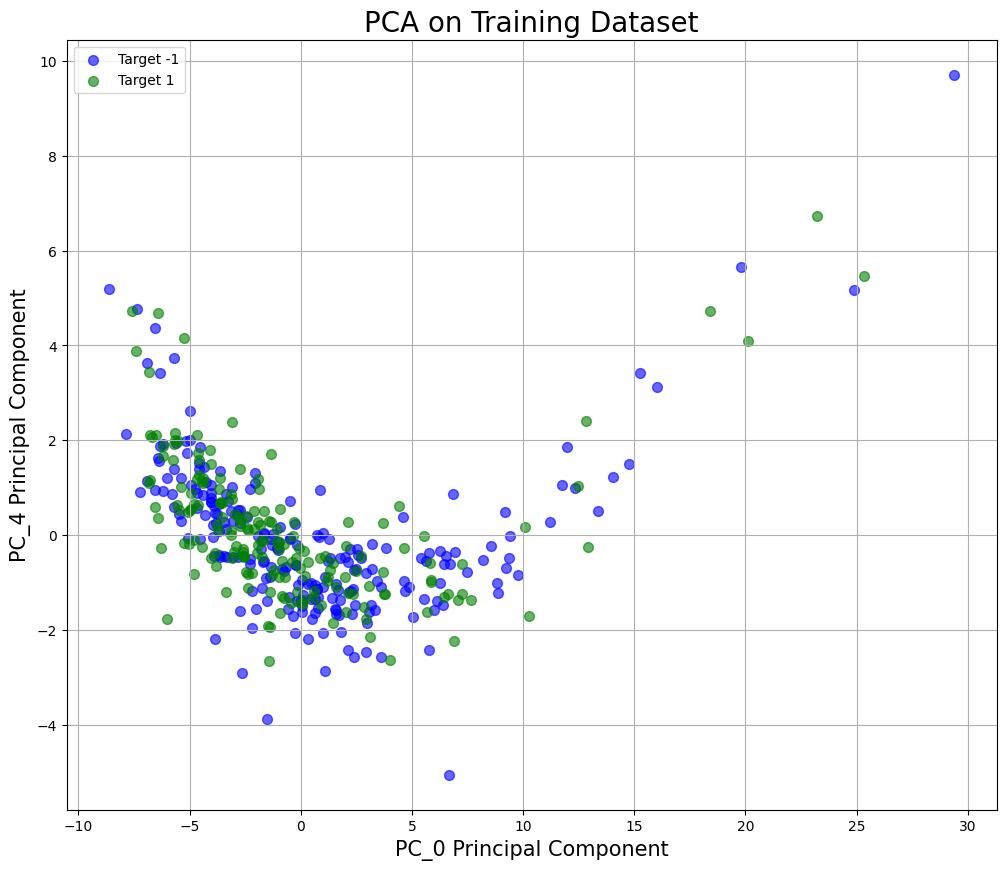

In [38]:
import polars as pl
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assuming df_pca is your Polars DataFrame with the PCA results
# and y_train is your target variable

# Perform PCA (adjust n_components as needed)
n_components = 8  # The transcript suggests 7 or 8 components
pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(df_pca)

# Create a new DataFrame with PCA results
pca_cols = [f"PC_{i}" for i in range(n_components)]
df_pca_result = pl.DataFrame(pca_result, schema=pca_cols)

# Add the target variable to the PCA result DataFrame
df_pca_result = df_pca_result.with_columns(pl.Series("target", y_train))

# Visualize Principal Components with Scatter Plot
fig, ax = plt.subplots(figsize=(12, 10))
col_1 = "PC_0"
col_2 = "PC_4"  # You can change this to compare different components

ax.set_xlabel(f"{col_1} Principal Component", fontsize=15)
ax.set_ylabel(f"{col_2} Principal Component", fontsize=15)
ax.set_title("PCA on Training Dataset", fontsize=20)

targets = [-1, 1]  # Adjust these values based on your actual targets
colors = ['b', 'g']

for target, color in zip(targets, colors):
    # Filter data based on target
    group = df_pca_result.filter(pl.col("target") == target)
    
    # Plot the group
    ax.scatter(
        group[col_1],
        group[col_2],
        c=color,
        s=50,
        alpha=0.6,
        label=f'Target {target}'
    )

ax.legend()
ax.grid()

# Print variance explained by principal components
variance_explained = pca.explained_variance_ratio_
print("Variance of each component:")
for i, var in enumerate(variance_explained):
    print(f"PC_{i}: {var:.4f}")

total_variance = sum(variance_explained)
print(f"\nTotal variance explained: {total_variance:.2%}")

plt.show()

```markdown
# Trading Strategy Development with PCA

We can develop a trading strategy using Principal Component Analysis (PCA) and machine learning techniques. Here's a step-by-step approach:

## 1. Dimensionality Reduction with PCA

We'll use PCA to reduce our high-dimensional feature set (80-90 features) to a more manageable set of 7-8 components, retaining about 80% of the information.

```python
import polars as pl
from sklearn.decomposition import PCA

# Assume df is our original dataframe with all features
n_components = 8
pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(df)

# Create a new DataFrame with PCA results
pca_cols = [f"PC_{i}" for i in range(n_components)]
df_pca = pl.DataFrame(pca_result, schema=pca_cols)

# Print variance explained
print("Variance explained by each component:")
for i, var in enumerate(pca.explained_variance_ratio_):
    print(f"PC_{i}: {var:.4f}")
print(f"\nTotal variance explained: {pca.explained_variance_ratio_.sum():.2%}")
```

## 2. Visualization

Let's visualize the principal components to identify patterns and separation of classes.

```python
import matplotlib.pyplot as plt

def plot_pca_components(df_pca, targets, col_1="PC_0", col_2="PC_1"):
    fig, ax = plt.subplots(figsize=(12, 10))
    
    colors = ['b', 'g']
    for target, color in zip(targets, colors):
        group = df_pca.filter(pl.col("target") == target)
        ax.scatter(
            group[col_1], group[col_2],
            c=color, s=50, alpha=0.6,
            label=f'Target {target}'
        )
    
    ax.set_xlabel(f"{col_1} Principal Component", fontsize=15)
    ax.set_ylabel(f"{col_2} Principal Component", fontsize=15)
    ax.set_title("PCA on Training Dataset", fontsize=20)
    ax.legend()
    ax.grid()
    plt.show()

# Assume 'target' column is added to df_pca
plot_pca_components(df_pca, targets=[-1, 1])
```

## 3. Predictive Modeling

Now, let's build a simple predictive model using the PCA-transformed data.

```python
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

X = df_pca.drop("target")
y = df_pca["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
```

## 4. K-means Clustering

As suggested in the transcript, let's apply K-means clustering to identify potential market regimes.

```python
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
df_pca = df_pca.with_columns(pl.Series("cluster", kmeans.fit_predict(df_pca.drop("target"))))

# Visualize clusters
plot_pca_components(df_pca, targets=[0, 1, 2], col_1="PC_0", col_2="PC_1")
```

## 5. Developing Trading Rules

Based on our predictive model and clustering results, we can develop simple trading rules:

```python
def trading_signal(pca_features, cluster):
    # This is a simple example - you'd want to develop more sophisticated rules
    prediction = model.predict([pca_features])[0]
    if prediction == 1 and cluster != 2:  # Assuming cluster 2 is high volatility
        return "BUY"
    elif prediction == -1 and cluster != 2:
        return "SELL"
    else:
        return "HOLD"

# Apply to test data
X_test["signal"] = X_test.apply(lambda row: trading_signal(row, row["cluster"]), axis=1)
```

## 6. Backtesting

Finally, we'd want to backtest our strategy. This would involve applying our trading rules to historical data and calculating returns. The specific implementation would depend on the structure of your data and the details of your trading approach.

```python
# Pseudo-code for backtesting
# for each day in backtest_period:
#     calculate_pca_features()
#     determine_cluster()
#     generate_signal()
#     calculate_returns()

# calculate_overall_performance()
```

Remember, this is a basic framework. In a real trading scenario, you'd need to consider transaction costs, risk management, and more sophisticated modeling techniques. Always thoroughly test any strategy before applying it to real trading.
```


### Supervised ML - Random Forest Classifcation

In [35]:
# Import necessary libraries for machine learning and data manipulation
import numpy as np
import polars as pl
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score

# Helper function to convert various data formats to numpy arrays
def to_numpy_array(data):
    if isinstance(data, pl.DataFrame):
        return data.to_numpy()
    elif isinstance(data, np.ndarray):
        return data
    else:
        raise TypeError(f"Unsupported data type: {type(data)}")

# Convert input data to numpy arrays if they aren't already
# This ensures compatibility with scikit-learn models
X_train_np = to_numpy_array(X_train)
y_train_np = to_numpy_array(y_train).ravel()  # Flatten y_train for the classifier
X_test_np = to_numpy_array(X_test)
y_test_np = to_numpy_array(y_test).ravel()  # Flatten y_test for evaluation

# Initialize the RandomForestClassifier with specified parameters
# n_estimators: number of trees in the forest
# max_depth: maximum depth of each tree
# random_state: seed used by the random number generator for reproducibility
classifier = RandomForestClassifier(n_estimators=12, max_depth=2, random_state=0)

# Fit the model to the training data
# This step trains the classifier on the training dataset
classifier.fit(X_train_np, y_train_np)

# Predict the test set results using the trained classifier
# This step generates predictions for the test dataset
y_pred = classifier.predict(X_test_np)

# Calculate accuracy and precision of the model on the test dataset
# accuracy_score: proportion of correct predictions
# precision_score: quality of the predictions, use 'weighted' for multi-class support
accuracy = accuracy_score(y_test_np, y_pred)
precision = precision_score(y_test_np, y_pred, average='weighted')

# Print the evaluation metrics
# These metrics help assess the performance of the trading model
print(f"Test Accuracy: {accuracy}")
print(f"Test Precision: {precision}")


Test Accuracy: 0.5750262329485835
Test Precision: 0.5672973180972565


In [37]:
# Predict the probabilities of each class for the test set
y_pred_proba = classifier.predict_proba(X_test)

# Output the probability estimates
print(y_pred_proba)


[[0.44702051 0.55297949]
 [0.69395028 0.30604972]
 [0.5400699  0.4599301 ]
 ...
 [0.5197293  0.4802707 ]
 [0.56974754 0.43025246]
 [0.50284562 0.49715438]]


In [41]:
# Test for Overfitting
# Initialize lists to store accuracy scores for training and test datasets
train_scores, test_scores = list(), list()
# Define a range of values for the number of estimators to test for overfitting
values = [i for i in range(1, 200)]

# Loop over the range of values
for i in values:
    # Initialize the RandomForestClassifier with varying number of estimators
    classifier = RandomForestClassifier(n_estimators=i, max_depth=2, random_state=0)
    # Fit the model to the training data
    classifier.fit(X_train_np, y_train_np)
    
    # Training Data
    # Predict the training data
    y_train_pred = classifier.predict(X_train_np)
    # Calculate the accuracy on the training data
    accuracy_train = accuracy_score(y_train_np, y_train_pred)
    # Append the training accuracy to the list
    train_scores.append(accuracy_train)
    
    # Test Data
    # Predict the test data
    y_test_pred = classifier.predict(X_test_np)
    # Calculate the accuracy on the test data
    accuracy_test = accuracy_score(y_test_np, y_test_pred)
    # Append the test accuracy to the list
    test_scores.append(accuracy_test)

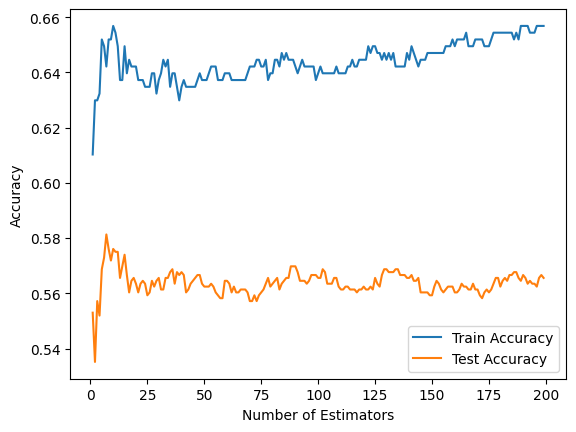

In [44]:
# Plotting the results to visualize overfitting
plt.plot(values, train_scores, label='Train Accuracy')
plt.plot(values, test_scores, label='Test Accuracy')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

"""
Trading Purpose:
1. **Model Evaluation**: This code helps in evaluating the performance of the RandomForestClassifier in predicting market movements.
2. **Overfitting Detection**: By analyzing the training and test accuracies, traders can detect overfitting, where the model performs exceptionally well on training data but poorly on unseen test data.
3. **Model Selection**: The plot helps in selecting the optimal number of estimators for the RandomForestClassifier, balancing bias and variance to improve model generalization.
4. **Confidence in Predictions**: Understanding overfitting and model accuracy boosts traders' confidence in making predictions based on the model's output.
"""

### Explanation of the Chart and Overfitting:

**Train Accuracy (blue line)**: This line represents the model's performance on the training data. As the number of estimators increases, the training accuracy typically improves because the model can capture more details from the training set.

**Test Accuracy (orange line)**: This line represents the model's performance on the unseen test data. Ideally, test accuracy should follow a similar trend to train accuracy.

### Overfitting Effects:

- **Initial Rise in Accuracy**: Both train and test accuracies increase as the model complexity (number of estimators) increases. This is because the model can better fit the data with more estimators.

- **Divergence**: After a certain point, the train accuracy continues to increase, while the test accuracy starts to level off or even decrease. This indicates overfitting, where the model is learning noise and details specific to the training data that do not generalize to the test data.

- **Optimal Point**: The point before the divergence where both train and test accuracies are high and close to each other is often the optimal model complexity, balancing bias and variance.

### In the provided chart:

- The train accuracy (blue line) increases steadily with the number of estimators.
- The test accuracy (orange line) initially increases but starts to fluctuate and slightly decrease as the number of estimators increases beyond a certain point.
- This behavior indicates overfitting, where the model is too complex and fits the training data too closely, leading to poorer performance on the test data.

### Trading Purpose:

Understanding the effects of overfitting helps traders select a model that generalizes well to new data, providing more reliable predictions for market movements. By detecting overfitting, traders can avoid models that perform well on historical data but fail in real-world scenarios, improving their trading strategy's robustness.
